## Prepare Notebook

In [1]:
import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import seaborn as sns

from jax import random
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoMultivariateNormal
from numpyro.infer.util import initialize_model, Predictive


az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Generate Synthetic Data

In [2]:
n = 500
rng_key, rng_subkey = random.split(rng_key)
x = random.uniform(rng_key, shape=(n,), minval=1, maxval=jnp.pi)
x = x.sort()
mu_true = jnp.sqrt(x + 0.5) * jnp.sin(9 * x)
sigma_true = 0.15 * x**2
rng_key, rng_subkey = random.split(rng_key)
y = mu_true + sigma_true * random.normal(rng_key, shape=(n,))

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

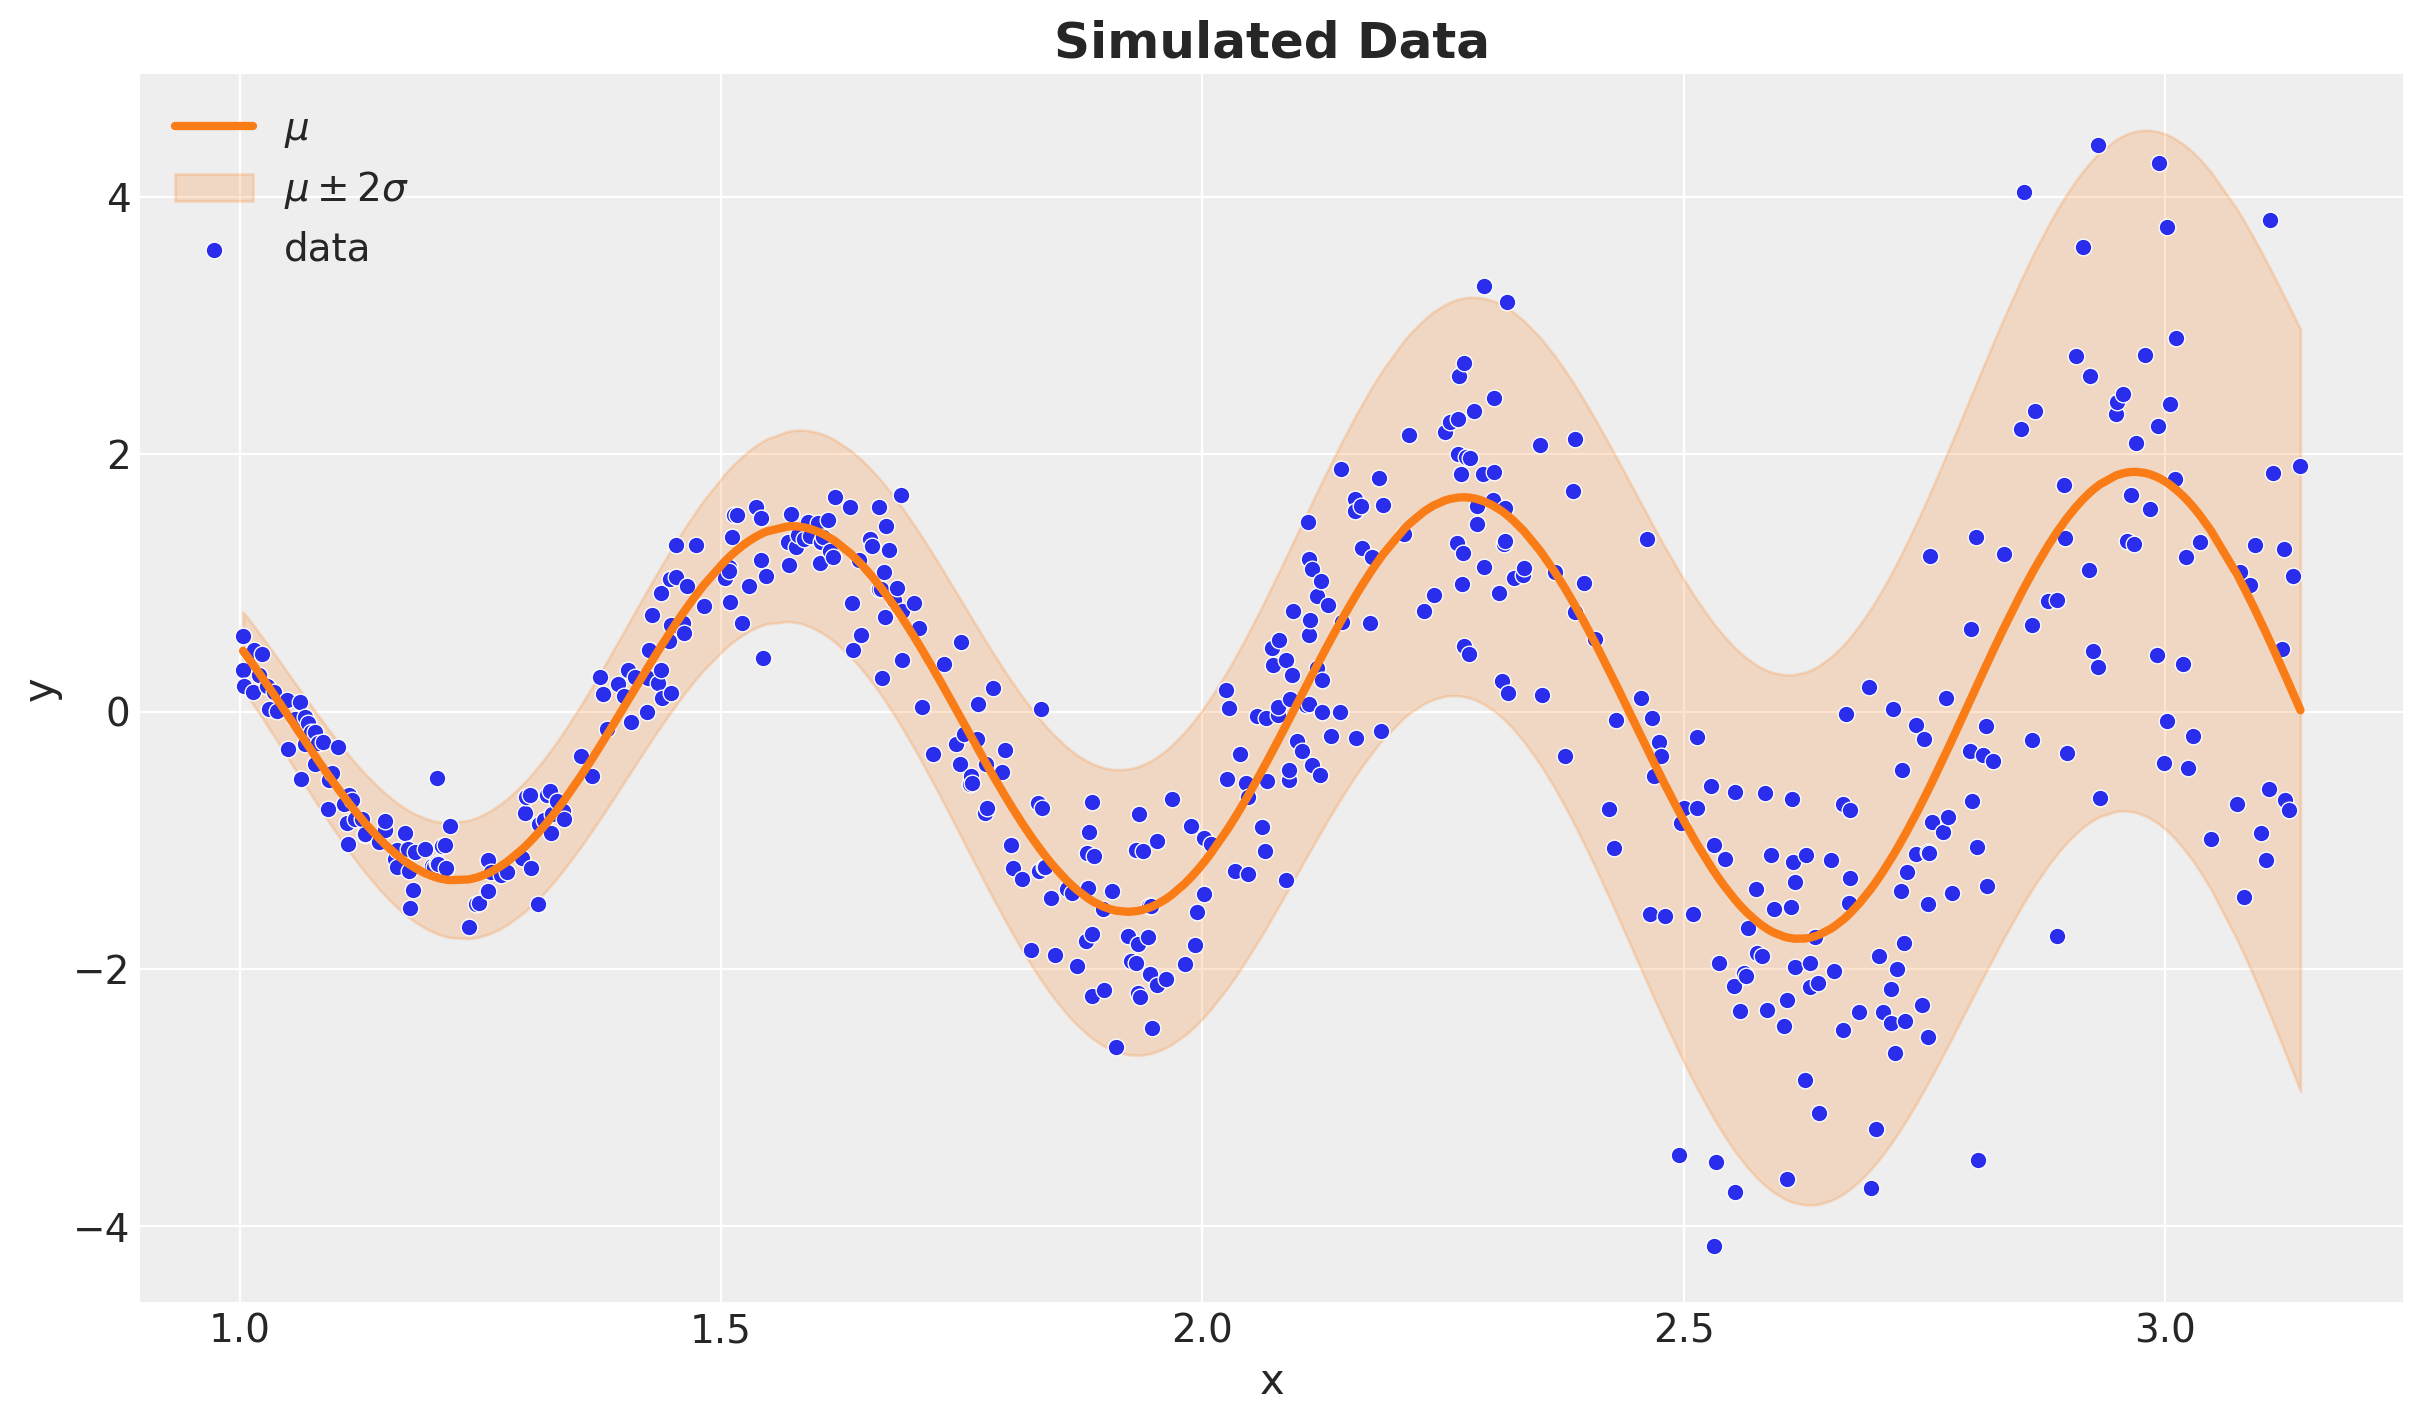

In [3]:
fig, ax = plt.subplots()
sns.lineplot(x=x, y=mu_true, color="C1", label=r"$\mu$", linewidth=3, ax=ax)
ax.fill_between(
    x,
    mu_true - 2 * sigma_true,
    mu_true + 2 * sigma_true,
    color="C1",
    alpha=0.2,
    label=r"$\mu \pm 2 \sigma$",
)
sns.scatterplot(x=x, y=y, color="C0", label="data", ax=ax)
ax.legend(loc="upper left")
ax.set_title(label="Simulated Data", fontsize=18, fontweight="bold")
ax.set(xlabel="x", ylabel="y")